In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from cpyImagingMSpec import ImzbReader
imzb = ImzbReader("/home/lomereiter/metabolomics/zebrafish_60x100.imzb")

Generate the centroided isotope pattern for one of detected molecules (not from the MALDI matrix)

In [2]:
sf = "C43H84NO8P+H"

from cpyMSpec import IsotopePattern
p = IsotopePattern(sf).charged(1)
# resolution is inversely proportional to sqrt(m/z) for Orbitrap
resolution = 140000 * (200 / p.masses[0])**0.5
p = p.centroids(resolution).trimmed(5)
print p

{
   774.6006: 100.0000%,
   775.6041:  47.7823%,
   776.6071:  12.5987%,
   777.6102:   2.4066%,
   778.6128:   0.3678%
}


Let's grab m/z images for the top two isotopic peaks (with 2 ppm window):

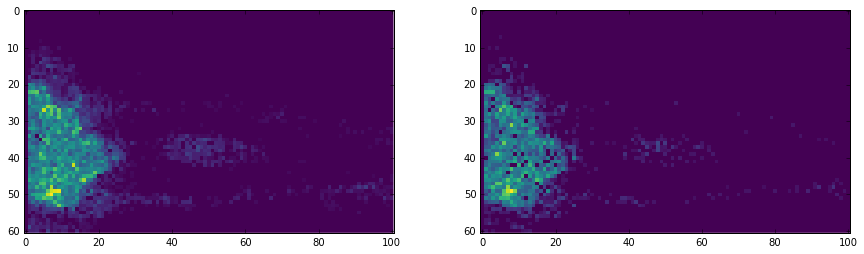

In [3]:
i1 = imzb.get_mz_image(p.masses[0], 2)
i2 = imzb.get_mz_image(p.masses[1], 2)
i1[i1 < 0] = 0; i2[i2 < 0] = 0

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.imshow(i1, cmap='viridis', interpolation='none');
plt.subplot(1, 2, 2)
plt.imshow(i2, cmap='viridis', interpolation='none');

Clean the data by keeping only those pixels where both intensities are positive:

In [4]:
i1p = i1[(i1 > 0) & (i2 > 0)]
i2p = i2[(i1 > 0) & (i2 > 0)]

Plotting square roots of the isotope intensities shows that the transformation roughly stabilizes variance:

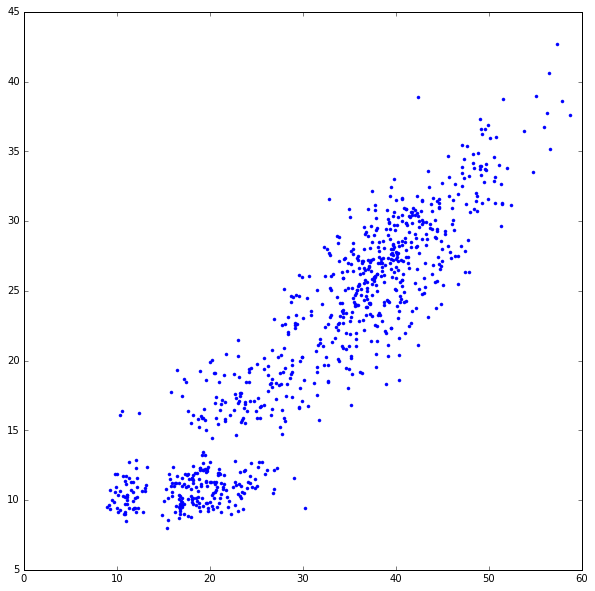

In [5]:
plt.figure(figsize=(10, 10))
plt.plot(i1p ** 0.5, i2p ** 0.5, '.');

We can also look at the residuals:

correlation:  -0.145080117098


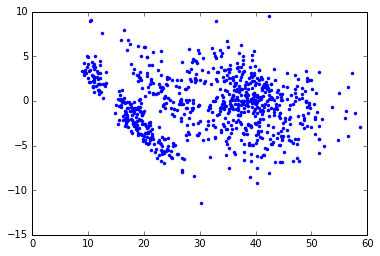

In [6]:
print "correlation: ", np.corrcoef(i1p ** 0.5, i2p ** 0.5 - i1p ** 0.5 * p.abundances[1] ** 0.5)[0, 1]
plt.plot(i1p ** 0.5, i2p ** 0.5 - i1p ** 0.5 * p.abundances[1] ** 0.5, '.');

Signal processing seems to have led to absence of an intensity range (white stripes on the plots above), which skews the residual distribution somewhat:

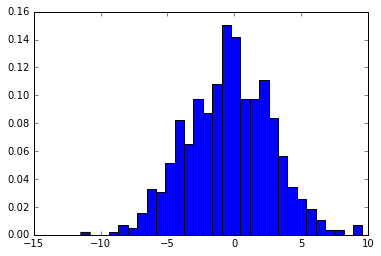

In [7]:
plt.hist(i2p ** 0.5 - i1p ** 0.5 * p.abundances[1] ** 0.5, 30, normed=1);

Normality test doesn't fail, however:

In [8]:
import scipy.stats
print scipy.stats.normaltest(i2p ** 0.5 - i1p ** 0.5 * p.abundances[1] ** 0.5)

NormaltestResult(statistic=0.095016240735018326, pvalue=0.95360272949656455)


We can also look check normality for top N% of intensities:

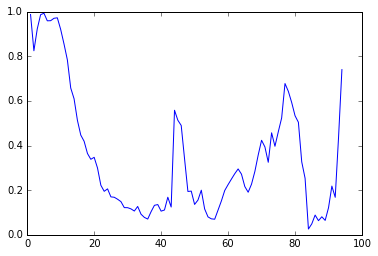

In [24]:
percents = range(1, 95)
pvs = []
pwr = 0.5
for perc in percents:
    r = i1p > np.percentile(i1p, perc)
    pvs.append(scipy.stats.normaltest(i2p[r] ** pwr - i1p[r] ** pwr * p.abundances[1] ** pwr).pvalue)
plt.plot(percents, pvs);